# Understanding Fitters



In [1]:
from IPython.display import display_markdown

import pint.toa
import pint.models
import pint.fitter
import pint.config
import pint.logging

pint.logging.setup(level="INFO")

1

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Turn on quantity support for plotting. This is very helpful!
from astropy.visualization import quantity_support

quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f21515ef390>

In [3]:
# Load some TOAs and a model to fit
m, t = pint.models.get_model_and_toas(
    pint.config.examplefile("NGC6440E.par"), pint.config.examplefile("NGC6440E.tim")
)

In [4]:
# You can check if a model includes a noise model with correlated errors (e.g. ECORR or TNRED) by checking the has_correlated_errors property
m.has_correlated_errors

False

There are several fitters in PINT, each of which is a subclass of `Fitter`

* `DownhillWLSFitter` - PINT's workhorse fitter, which does a basic weighted least-squares minimization of the residuals.
* `DownhillGLSFitter` - A generalized least squares fitter, like "tempo -G", that can handle noise processes like ECORR and red noise that are specified by their correlation function properties.
* `WidebandDownhillFitter` - A fitter that uses DM estimates associated with each TOA. Also supports generalized least squares.
* `PowellFitter` - A very simple example fitter that uses the Powell method implemented in scipy. One notable feature is that it does not require evaluating derivatives w.r.t the model parameters.
* `MCMCFitter` - A fitter that does an MCMC fit using the [emcee](https://emcee.readthedocs.io/en/stable/) package. This can be very slow, but accomodates Priors on the parameter values and can produce corner plots and other analyses of the posterior distributions of the parameters.
* `WLSFitter`, `GLSFitter`, `WidebandFitter` - Simpler fitters that make no attempt to ensure convergence.

You can normally use the function `pint.fitter.Fitter.auto(toas, model)` to construct an appropriate fitter for your model and data.


## Weighted Least Squares Fitter

In [5]:
# Instantiate a fitter
wlsfit = pint.fitter.DownhillWLSFitter(toas=t, model=m)

A fit is performed by calling `fit_toas()`

For most fitters, multiple iterations can be limited by setting the `maxiter` keyword argument.

Downhill fitters will raise the `pint.fitter.MaxiterReached` exception if they stop before detecting convergence; you can capture this exception and continue if you don't mind not having the best-fit answer.

In [6]:
try:
    wlsfit.fit_toas(maxiter=1)
except pint.fitter.MaxiterReached:
    print("Fitter has not fully converged.")

Fitter has not fully converged.


In [7]:
# A summary of the fit and resulting model parameters can easily be printed
# Only free parameters will have values and uncertainties in the Postfit column
wlsfit.print_summary()

Fitted model using downhill_wls method with 5 free parameters to 62 TOAs
Prefit residuals Wrms = 1090.5801805746107 us, Postfit residuals Wrms = 21.18210874551586 us
Chisq = 59.575 for 56 d.o.f. for reduced Chisq of 1.064

PAR                        Prefit                  Postfit            Units
=================== ==================== ============================ =====
PSR                           1748-2021E 1748-2021E                   None
EPHEM                              DE421 DE421                        None
CLOCK                       TT(BIPM2019) TT(BIPM2019)                 None
UNITS                                TDB TDB                          None
START                                                         53478.3 d 
FINISH                                                        54187.6 d 
TIMEEPH                             FB90 FB90                         None
T2CMETHOD                       IAU2000B IAU2000B                     None
DILATEFREQ                   

In [8]:
# The WLS fitter doesn't handle correlated errors
wlsfit.resids.model.has_correlated_errors

False

In [9]:
# You can request a pretty-printed covariance matrix
cov = wlsfit.get_parameter_covariance_matrix(pretty_print=True)


Parameter covariance matrix:
               RAJ       DECJ        F0         F1         DM     
    RAJ      1.411e-15
   DECJ     -2.477e-14  8.328e-11
    F0      -5.932e-20  4.079e-17  3.271e-22
    F1       1.594e-26 -4.525e-24 -2.080e-29  2.079e-36
    DM      -6.523e-12  2.067e-08  4.261e-15  2.900e-21  1.221e-03




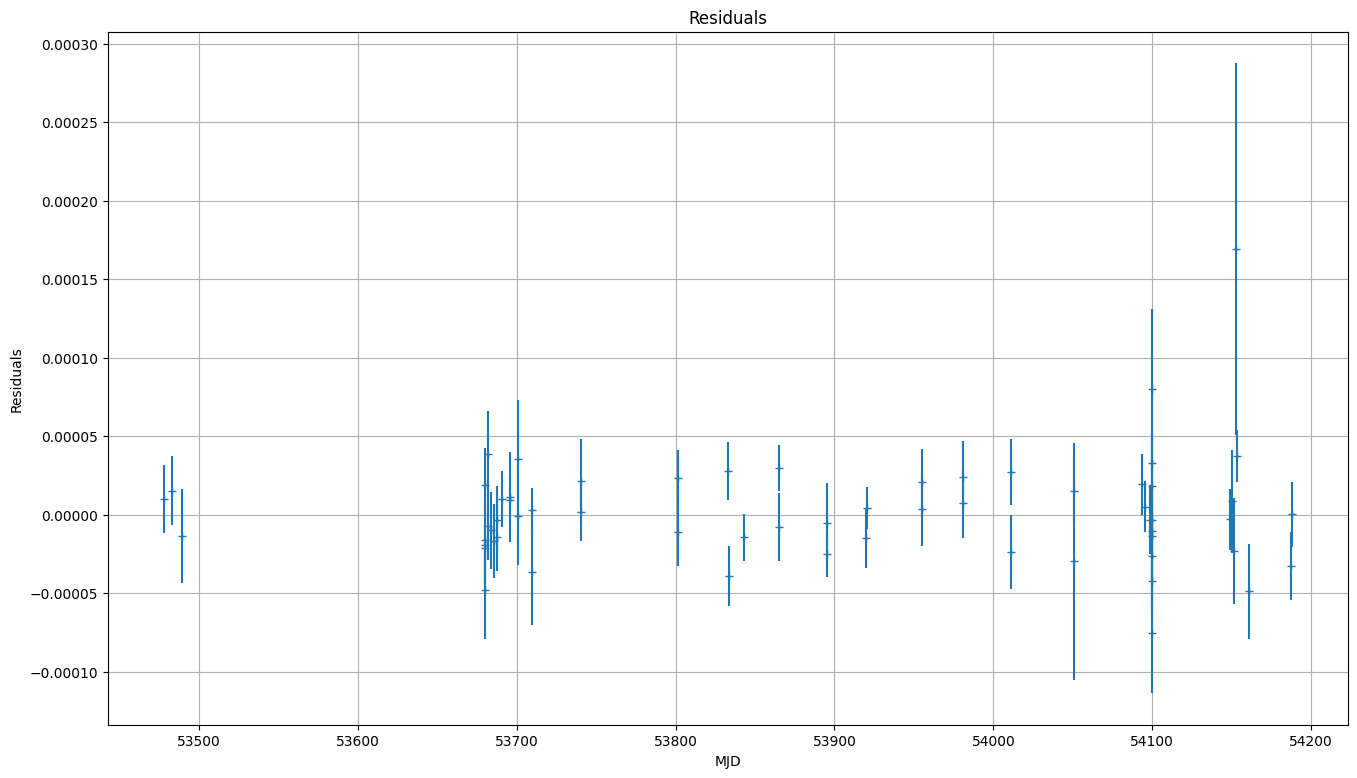

In [10]:
# plot() will make a plot of the post-fit residuals
wlsfit.plot()


## Comparing models

There also a convenience function for pretty printing a comparison of two models with the differences measured in sigma.

In [11]:
display_markdown(wlsfit.model.compare(wlsfit.model_init, format="markdown"), raw=True)

| PARAMETER | NGC6440E.par | NGC6440E.par | Diff_Sigma1 | Diff_Sigma2 |
 :--- | ---: | ---: | ---: | ---: |
PSR | 1748-2021E | 1748-2021E |  |
EPHEM | DE421 | DE421 |  |
CLOCK | TT(BIPM2019) | TT(BIPM2019) |  |
UNITS | TDB | TDB |  |
START | 53478.285871419538264 | Missing |  |
FINISH | 54187.58732417023191 | Missing |  |
TIMEEPH | FB90 | FB90 |  |
T2CMETHOD | IAU2000B | IAU2000B |  |
DILATEFREQ | False | False |  |
DMDATA | False | False |  |
NTOA | 62 | 0 |  |
CHI2 | 59.574713494278086 | Missing |  |
CHI2R | 1.06383416954068 | Missing |  |
TRES | 21.182108745515856993 | Missing |  |
POSEPOCH | 53750.0 | 53750.0 |  |
PX | 0.0 | 0.0 |  |
<mark><span style='color:red'>**RAJ**</span></mark> | <mark><span style='color:red'>**17h48m52.80034691s +/- 0.00014**</span></mark> | <mark><span style='color:red'>**17h48m52.75s +/-    0.05**</span></mark> | <mark><span style='color:red'>**-372.26**</span></mark> | <mark><span style='color:red'>**-1.01**</span></mark>
<mark><span style='color:red'>**DECJ**</span></mark> | <mark><span style='color:red'>**-20d21m29.38331083s +/-   0.033**</span></mark> | <mark><span style='color:red'>**-20d21m29s +/-     0.4**</span></mark> | <mark><span style='color:red'>**11.67**</span></mark> | <mark><span style='color:red'>**0.96**</span></mark>
PMRA | 0.0 | 0.0 |  |
PMDEC | 0.0 | 0.0 |  |
<mark><span style='color:red'>**F0**</span></mark> | <mark><span style='color:red'>**61.485476554372(18)**</span></mark> | <mark><span style='color:red'>**61.4854765540(5)**</span></mark> | <mark><span style='color:red'>**-20.60**</span></mark> | <mark><span style='color:red'>**-0.74**</span></mark>
PEPOCH | 53750.0 | 53750.0 |  |
F1 | -1.1813(14)×10⁻¹⁵ | -1.1810(10)×10⁻¹⁵ | 0.23 | 0.33
CORRECT_TROPOSPHERE | False | False |  |
PLANET_SHAPIRO | False | False |  |
NE_SW | 0.0 | 0.0 |  |
SWP | 2.0 | 2.0 |  |
SWM | 0.0 | 0.0 |  |
<mark><span style='color:red'>**DM**</span></mark> | <mark><span style='color:red'>**224.114(35)**</span></mark> | <mark><span style='color:red'>**223.90(30)**</span></mark> | <mark><span style='color:red'>**-6.12**</span></mark> | <mark><span style='color:red'>**-0.71**</span></mark>
TZRMJD | 53801.386051200748497 | 53801.386051200748497 |  |
TZRSITE | 1 | 1 |  |
TZRFRQ | 1949.609 | 1949.609 |  |
SEPARATION | 0.805131 arcsec |  |  |

You can see just how much F1 changed.  Let's compare the $\chi^2$ values:

In [12]:
print(f"Pre-fit chi-squared value: {wlsfit.resids_init.chi2}")
print(f"Post-fit chi-squared value: {wlsfit.resids.chi2}")

Pre-fit chi-squared value: 157920.59715077005
Post-fit chi-squared value: 59.574713494278086


## Generalized Least Squares fitter

The GLS fitter is capable of handling correlated noise models.

It has some more complex options using the `maxiter`, `threshold`, and `full_cov` keyword arguments to `fit_toas()`.

If `maxiter` is less than one, **no fitting is done**, just the
chi-squared computation. In this case, you must provide the `residuals`
argument.

If `maxiter` is one or more, so fitting is actually done, the
chi-squared value returned is only approximately the chi-squared
of the improved(?) model. In fact it is the chi-squared of the
solution to the linear fitting problem, and the full non-linear
model should be evaluated and new residuals produced if an accurate
chi-squared is desired.

A first attempt is made to solve the fitting problem by Cholesky
decomposition, but if this fails singular value decomposition is
used instead. In this case singular values below threshold are removed.

`full_cov` determines which calculation is used. If True, the full
covariance matrix is constructed and the calculation is relatively
straightforward but the full covariance matrix may be enormous.
If False, an algorithm is used that takes advantage of the structure
of the covariance matrix, based on information provided by the noise
model. The two algorithms should give the same result up to numerical
accuracy where they both can be applied.

To test this fitter properly, we need a model that includes correlated noise components, so we will load one from NANOGrav 9yr data release.

In [13]:
m1855 = pint.models.get_model(pint.config.examplefile("B1855+09_NANOGrav_9yv1.gls.par"))

In [14]:
# You can check if a model includes a noise model with correlated errors (e.g. ECORR or TNRED) by checking the has_correlated_errors property
m1855.has_correlated_errors

True

In [15]:
print(m1855)

# Created: 2024-05-01T16:54:38.736600
# PINT_version: 1.0+37.g68701b9
# User: docs
# Host: build-24247204-project-85767-nanograv-pint
# OS: Linux-5.19.0-1028-aws-x86_64-with-glibc2.35
# Python: 3.11.6 (main, Feb  1 2024, 16:47:41) [GCC 11.4.0]
# Format: pint
PSR                              B1855+09
EPHEM                               DE421
CLK                          TT(BIPM2019)
UNITS                                 TDB
START              53358.7260000000000000
FINISH             56598.8730000000000000
INFO                                   -f
TIMEEPH                              FB90
DILATEFREQ                              N
DMDATA                                  N
NTOA                                 4005
TRES                                 5.52
LAMBDA                286.863489330115613 1 0.00000001658590000000
BETA                   32.321487755503703 1 0.00000002735260000000
PMLAMBDA                          -3.2701 1 0.0141
PMBETA                            -5.0982 1 0.0291
P

In [16]:
ts1855 = pint.toa.get_TOAs(
    pint.config.examplefile("B1855+09_NANOGrav_9yv1.tim"), model=m1855
)
ts1855.print_summary()

Number of TOAs:  4005
Number of commands:  1
Number of observatories: 1 ['arecibo']
MJD span:  53358.727 to 56598.872
Date span: 2004-12-19 17:27:32.961266179 to 2013-11-02 20:55:40.399171358
arecibo TOAs (4005):
  Min freq:      422.187 MHz
  Max freq:      1760.728 MHz
  Min error:     0.05 us
  Max error:     17.8 us
  Median error:  1.19 us



There is currently a problem with `DownhillGLSFitter`: it doesn't record appropriate noise parameters.

In [17]:
glsfit = pint.fitter.GLSFitter(toas=ts1855, model=m1855)

In [18]:
m1855.DMX_0001.prefix

'DMX_'

In [19]:
glsfit.fit_toas(maxiter=1)

3900.0981532531170273

In [20]:
glsfit.print_summary()

Fitted model using generalized_least_square method with 90 free parameters to 4005 TOAs
Prefit residuals Wrms = 5.5386698946489625 us, Postfit residuals Wrms = 1.346783684962562 us
Chisq = 3900.098 for 3914 d.o.f. for reduced Chisq of 0.996

PAR                        Prefit                  Postfit            Units
=================== ==================== ============================ =====
PSR                             B1855+09 B1855+09                     None
EPHEM                              DE421 DE421                        None
CLOCK                       TT(BIPM2019) TT(BIPM2019)                 None
UNITS                                TDB TDB                          None
START                            53358.7                      53358.7 d 
FINISH                           56598.9                      56598.9 d 
INFO                                  -f -f                           None
TIMEEPH                             FB90 FB90                         None
BINARY    

The GLS fitter produces two types of residuals, the normal residuals to the deterministic model and those from the noise model.

In [21]:
glsfit.resids.time_resids

<Quantity [-2.60443875e-06, -1.24724146e-06,  4.11893693e-07, ...,
            1.26318741e-06, -3.26992736e-07,  4.35625528e-06] s>

In [22]:
glsfit.resids.noise_resids

{'pl_red_noise': <Quantity [-1.27090740e-06, -1.27090740e-06, -1.27090740e-06, ...,
            -1.27096267e-06, -1.27096267e-06, -1.27096267e-06] s>,
 'ecorr_noise': <Quantity [-7.68053637e-11, -7.68053637e-11, -7.68053637e-11, ...,
             3.75218951e-07,  3.75218951e-07,  3.75218951e-07] s>}

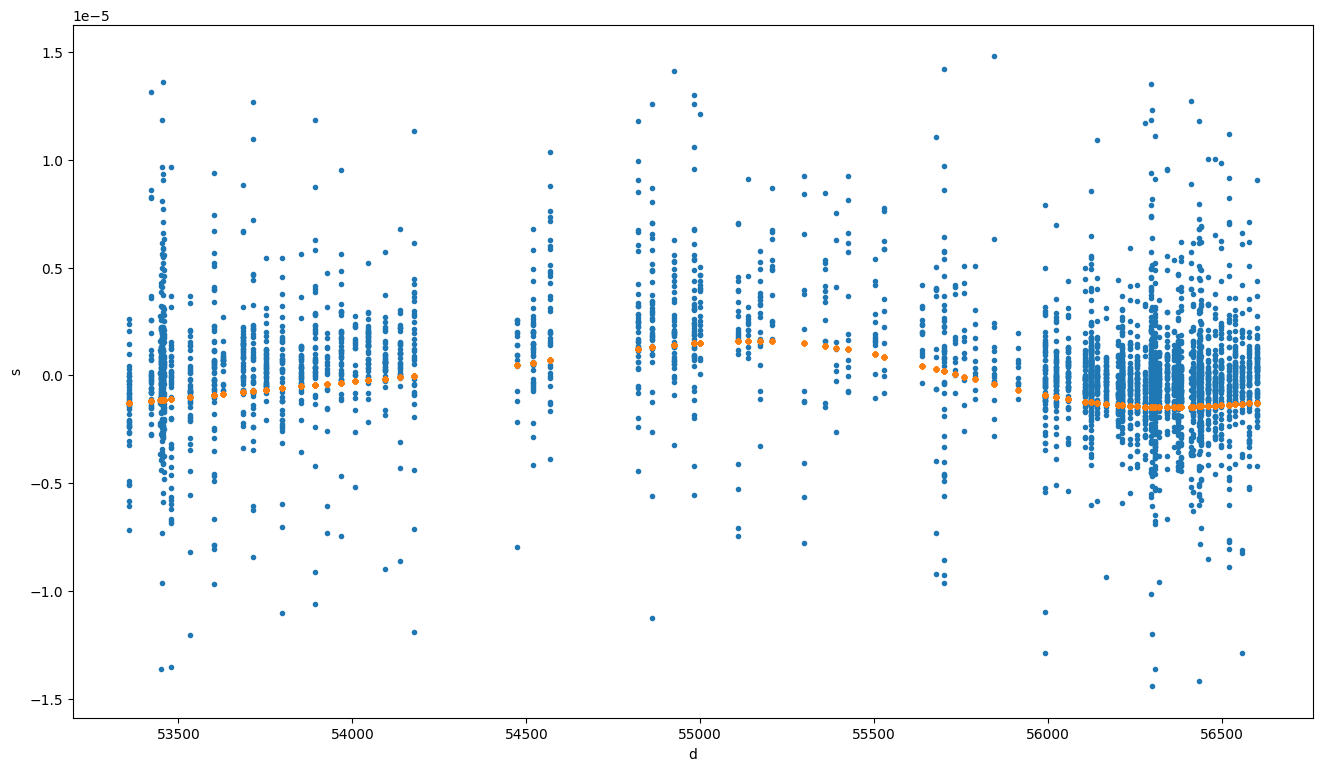

In [23]:
# Here we can plot both the residuals to the deterministic model as well as the realization of the noise model residuals
# The difference will be the "whitened" residuals
fig, ax = plt.subplots(figsize=(16, 9))
mjds = glsfit.toas.get_mjds()
ax.plot(mjds, glsfit.resids.time_resids, ".")
ax.plot(mjds, glsfit.resids.noise_resids["pl_red_noise"], ".")

## Choosing fitters

You can use the automatic fitter selection to help you choose between `WLSFitter`, `GLSFitter`, and their wideband variants.
The default `Downhill` fitters generally have better performance than the plain variants.

In [24]:
autofit = pint.fitter.Fitter.auto(toas=ts1855, model=m1855)

In [25]:
autofit.fit_toas()

True

In [26]:
display_markdown(autofit.model.compare(glsfit.model, format="markdown"), raw=True)

| PARAMETER | B1855+09_NANOGrav_9yv1.gls.par | B1855+09_NANOGrav_9yv1.gls.par | Diff_Sigma1 | Diff_Sigma2 |
 :--- | ---: | ---: | ---: | ---: |
PSR | B1855+09 | B1855+09 |  |
EPHEM | DE421 | DE421 |  |
CLOCK | TT(BIPM2019) | TT(BIPM2019) |  |
UNITS | TDB | TDB |  |
START | 53358.727464829469664 | 53358.727464829469664 |  |
FINISH | 56598.871995360779607 | 56598.871995360779607 |  |
INFO | -f | -f |  |
TIMEEPH | FB90 | FB90 |  |
BINARY | DD | DD |  |
DILATEFREQ | False | False |  |
DMDATA | False | False |  |
NTOA | 4005 | 4005 |  |
CHI2 | 3900.099335413064 | 3900.098153253117 |  |
CHI2R | 0.9964484760891835 | 0.9964481740554719 |  |
<span style='color:red'>**TRES**</span> | <span style='color:red'>**1.346626340034325379**</span> | <span style='color:red'>**1.3467836849625620117**</span> |  |
POSEPOCH | 54978.0 | 54978.0 |  |
PX | 0.30(22) | 0.30(22) | 0.00 | 0.00
ELONG | 286d51m48.56156713s +/- 5.9e-05 | 286d51m48.56156705s +/- 5.9e-05 | -0.00 | -0.00
ELAT | 32d19m17.35582884s +/- 9.7e-05 | 32d19m17.35582847s +/- 9.8e-05 | -0.00 | -0.00
PMELONG | -3.270(14) | -3.270(14) | 0.00 | 0.00
PMELAT | -5.099(29) | -5.099(29) | -0.00 | -0.00
ECL | IERS2003 | IERS2003 |  |
F0 | 186.49408127078522(27) | 186.49408127078522(27) | 0.00 | 0.00
PEPOCH | 54978.0 | 54978.0 |  |
F1 | -6.20497(25)×10⁻¹⁶ | -6.20497(25)×10⁻¹⁶ | -0.00 | -0.00
CORRECT_TROPOSPHERE | False | False |  |
PLANET_SHAPIRO | False | False |  |
NE_SW | 0.0 | 0.0 |  |
SWP | 2.0 | 2.0 |  |
SWM | 0.0 | 0.0 |  |
DM | 13.299393 | 13.299393 |  |
PB | 12.32717119133(20) | 12.32717119133(20) | -0.00 | -0.00
PBDOT | 0.0 | 0.0 |  |
A1 | 9.23078048(20) | 9.23078048(20) | -0.00 | -0.00
A1DOT | 0.0 | 0.0 |  |
ECC | 2.1634(24)×10⁻⁵ | 2.1634(24)×10⁻⁵ | 0.00 | 0.00
EDOT | 0.0 | 0.0 |  |
<mark>T0</mark> | <mark>54975.5128(8)</mark> | <mark>54975.5128(19)</mark> | <mark>-0.07</mark> | <mark>-0.03</mark>
<mark>OM</mark> | <mark>276.535(23)</mark> | <mark>276.53(6)</mark> | <mark>-0.07</mark> | <mark>-0.03</mark>
OMDOT | 0.0 | 0.0 |  |
M2 | 0.234(11) | 0.234(11) | 0.00 | 0.00
SINI | 0.99946(18) | 0.99946(18) | -0.00 | -0.00
A0 | 0.0 | 0.0 |  |
B0 | 0.0 | 0.0 |  |
GAMMA | 0.0 | 0.0 |  |
DR | 0.0 | 0.0 |  |
DTH | 0.0 | 0.0 |  |
FD1 | 0.000162(34) | 0.000162(34) | 0.00 | 0.00
FD2 | -0.00019(4) | -0.00019(4) | -0.00 | -0.00
FD3 | 0.000108(25) | 0.000108(25) | 0.00 | 0.00
RNAMP | 0.017173 | 0.017173 |  |
RNIDX | -4.91353 | -4.91353 |  |
TNREDAMP | -14.227505410948254 | -14.227505410948254 |  |
TNREDGAM | 4.91353 | 4.91353 |  |
TNREDC | 45.0 | 45.0 |  |
ECORR1 | 0.00601 | 0.00601 |  |
ECORR2 | 0.31843 | 0.31843 |  |
ECORR3 | 0.79618 | 0.79618 |  |
ECORR4 | 0.01117 | 0.01117 |  |
EFAC1 | 1.507 | 1.507 |  |
EQUAD1 | 0.25518 | 0.25518 |  |
EFAC2 | 1.147 | 1.147 |  |
EFAC3 | 1.15 | 1.15 |  |
EFAC4 | 1.117 | 1.117 |  |
EQUAD2 | 0.0141 | 0.0141 |  |
EQUAD3 | 0.42504 | 0.42504 |  |
EQUAD4 | 0.0264 | 0.0264 |  |
TZRMJD | 54981.28084616488447 | 54981.28084616488447 |  |
TZRSITE | 3 | 3 |  |
TZRFRQ | 424.0 | 424.0 |  |
JUMP1 | -9(9)×10⁻⁶ | -9(9)×10⁻⁶ | 0.00 | 0.00
SEPARATION | 0.000000 arcsec |  |  |

The results are (thankfully) identical.

The MCMC fitter is considerably more complicated, so it has its own dedicated walkthroughs in `MCMC_walkthrough.ipynb`
(for photon data) and `examples/fit_NGC6440E_MCMC.py` (for fitting TOAs).